# Machine Learning Engineer Nanodegree
## Lin Muqing
## Capstone Data Exploration

In [1]:
# Import libraries necessary for this project
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gc
import seaborn as sns
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
if not os.path.exists('figs'):
    os.mkdir('figs')

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Load raw dataset
prop_data = pd.read_csv('data/properties_2017.csv', header=0)
error_data = pd.read_csv('data/train_2017.csv', header=0)

In [3]:
# get error data transaction date to month
error_data['sale_month'] = error_data['transactiondate'].apply(lambda x: x.split('-')[1])  
error_data['abs_logerror'] = np.abs(error_data['logerror'])
# merge to train data set
train_data = error_data.merge(prop_data, on='parcelid', how='left')
train_data.to_csv('data/train_data_merged.csv', index=False)

In [4]:
train_data = pd.read_csv('data/train_data_merged.csv', header=0)
prop_data_copy = prop_data.copy()
train_data_copy = train_data.copy()

In [5]:
# shape of data
n_total = prop_data.shape[0]
n_train = train_data.shape[0]
print('total_data shape: ' + str(prop_data.shape))
print('train_data shape: ' + str(train_data.shape))

total_data shape: (2985217, 58)
train_data shape: (77613, 62)


In [6]:
feature_cols = ['new_name', 'type', 'class', 'prop_missing', 'train_missing']
feature_info = {}

In [7]:
# util functions
def col_fill_na(data, col, fill):
    if fill == 'mode':
        data[col].fillna(data[col].mode().values[0], inplace=True)
    elif fill == 'mean':
        data[col].fillna(data[col].mean(), inplace=True)
    elif fill == '0':
        data[col].fillna(0, inplace=True)
    else:
        print('unknown fill type: %s' % fill)
        

def recover_col(col):
    prop_data[col] = prop_data_copy[col].copy()
    train_data[col] = train_data_copy[col].copy()


def save_feature_info_to_csv():
    feature_info_df = pd.DataFrame(feature_info)
    feature_info_df = feature_info_df.T
    feature_info_df.columns = feature_cols
    feature_info_df.to_csv('data/feature_info.csv', index_label='orig_name', float_format='%.4f')


def cat_num_to_str(col_name):
    """for numeric-like categorical varible, transform to string, keep nan"""
    if not prop_data[col_name].dtype == 'O':
        prop_data[col_name] = prop_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)
    if not train_data[col_name].dtype == 'O':
        train_data[col_name] = train_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)


def mark_flag_col(col_name):
    """mark bool for numerical columns, mark True for val > 0, and False otherwise (include NaN)"""
    prop_data_marks_true = prop_data[col_name] >= 0.5
    prop_data.loc[prop_data.index[prop_data_marks_true], col_name] = 'TRUE'
    prop_data.loc[prop_data.index[~prop_data_marks_true], col_name] = 'FALSE'
    train_data_marks_true = train_data[col_name] >= 0.5
    train_data.loc[train_data.index[train_data_marks_true], col_name] = 'TRUE'
    train_data.loc[train_data.index[~train_data_marks_true], col_name] = 'FALSE'

        
def cat_feature_analysis(col_name):
    """analysis of categorical feature, comparing number of unique appeared values between train_data and prop_data, with NaN removed.
       For those values appear in train but not in prop, need to properly handle for prop in prediction."""    
    prop_col_no_nan = prop_data[col_name][~prop_data[col_name].isnull()]
    train_col_no_nan = train_data[col_name][~train_data[col_name].isnull()]
    vals_prop = np.sort(prop_col_no_nan.unique())
    vals_train = np.sort(train_col_no_nan.unique())
    if len(vals_train) < 15:
        print('vals from train_data: %s' % ', '.join([str(v) for v in vals_train]))
    val_prop_de_train = set(vals_prop) - set(vals_train)
    print('n_vals from train_data: %d' % len(vals_train))
    if val_prop_de_train:
        if len(val_prop_de_train) < 15:
            print('vals in prop not in train: %s' % ', '.join([str(v) for v in sorted(list(val_prop_de_train))]))
        print('n_vals in prop not in train: %d' % len(val_prop_de_train))
        # summarize ratio of not appeared-in-training value samples in total porpulation
        n_sample = np.sum(np.array([i in val_prop_de_train for i in prop_data[col_name]]))
        print('ratio sample with val in prop not in train: %4.6f' % (n_sample / float(n_total)))
    else:
        print('prop and train vals set consistent')
    return val_prop_de_train 


def missing_ratio(col_name):
    """compare missing rate in prop data and train data. A good feature should have similar ratio in both training and total population."""
    prop_missing = np.sum(prop_data[col_name].isnull()) / float(n_total)
    train_missing = np.sum(train_data[col_name].isnull()) / float(n_train)
    print('missing ratio prop: %4.4f' % prop_missing)
    print('missing ratio train: %4.4f' % train_missing)
    return prop_missing, train_missing
    

def visual_analysis_num(col_name, col_name_disp):
    """view relationship to error for numerical variables, summarize for NaN separately"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.kdeplot(train_data[col_name], bw=0.5, ax=ax1).set_title('density')  # 1, density plot
    fit_logerror = lowess(train_data['logerror'], train_data[col_name], return_sorted =False, it=0)
    sns.regplot(train_data[col_name], fit_logerror, fit_reg=False, ax=ax2).set_title('against logerror')  # 2, logerror
    fit_abs_logerror = lowess(train_data['abs_logerror'], train_data[col_name], return_sorted =False, it=0)
    sns.regplot(train_data[col_name], fit_abs_logerror, fit_reg=False, ax=ax3).set_title('against abs_logerror')  # 3, abs_logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    fig.savefig('figs/explore_%s.png' % col_name_disp)


def visual_analysis_cat(col_name, col_name_disp):
    """view relationship to error for categorical variables"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.countplot(train_data[col_name], ax=ax1).set_title('density')  # 1, density plot
    sns.barplot(x=col_name, y='logerror', data=train_data, ax=ax2).set_title('against logerror')  # 2, logerror
    sns.barplot(x=col_name, y='abs_logerror', data=train_data, ax=ax3).set_title('against abs logerror')  # 3, logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    fig.savefig('figs/explore_%s.png' % col_name_disp)
    
    
def visual_analysis_num_as_cat(col_name, col_name_disp):
    """kde density and regression line could be misleading for small-finite-set int variable, plot is as categorical"""
    cal_name_as_cat = col_name + 'as_cat'
    train_data[cal_name_as_cat] = train_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)
    groups = np.array(train_data[cal_name_as_cat].unique())
    order = np.array([float(i) for i in groups]).argsort()
    ordered_groups = groups[order]
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.countplot(train_data[cal_name_as_cat], order=ordered_groups, ax=ax1).set_title('density')  # 1, density plot
    sns.barplot(x=cal_name_as_cat, y='logerror', data=train_data, order=ordered_groups, ax=ax2).set_title('against logerror')  # 2, logerror
    sns.barplot(x=cal_name_as_cat, y='abs_logerror', data=train_data, order=ordered_groups, ax=ax3).set_title('against abs logerror')  # 3, logerror
    fig.suptitle('exploration for %s' % col_name_disp)
    fig.show()
    fig.savefig('figs/explore_%s_as_cat.png' % col_name_disp)

### airconditioningtypeid

Description: Type of cooling system present in the home (if any). And further description gives

| Type ID  | Description  |
|----------|---|
|1	     |Central|
|2	     |Chilled Water|
|3	     |Evaporative Cooler|
|4	     |Geo Thermal|
|5	     |None|
|6	     |Other|
|7	     |Packaged AC Unit|
|8	     |Partial|
|9	     |Refrigeration|
|10	     |Ventilation|
|11	     |Wall Unit|
|12	     |Window Unit|
|13	     |Yes|

From where we can see it is a categorical variable. And None is already included in description, so NaN is trully missing.


data type:float64
vals from train_data: 1, 11, 13, 5, 9
n_vals from train_data: 5
vals in prop not in train: 12, 3
n_vals in prop not in train: 2
ratio sample with val in prop not in train: 0.000022
missing ratio prop: 0.7269
missing ratio train: 0.6778


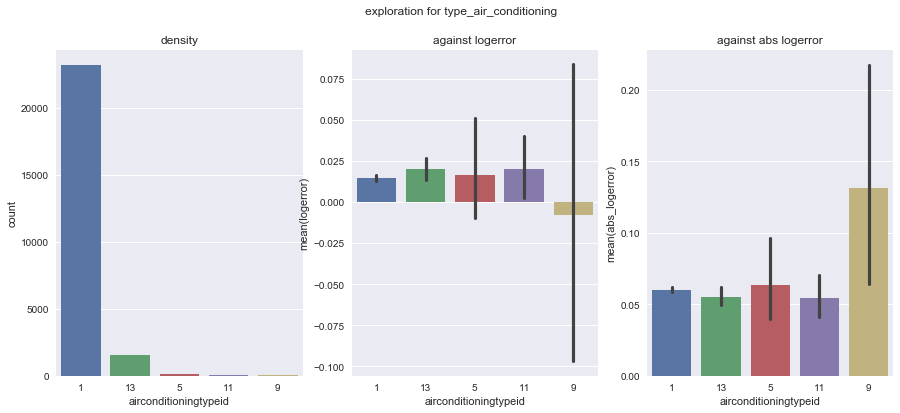

In [8]:
print('data type:' + str(prop_data['airconditioningtypeid'].dtype))
cat_num_to_str('airconditioningtypeid')
cat_feature_analysis('airconditioningtypeid')
prop_missing, train_missing = missing_ratio('airconditioningtypeid')
visual_analysis_cat('airconditioningtypeid', 'type_air_conditioning')

In [9]:
# Relatively high missing rate, imbalanced group distribution, and not much difference between two groups.
feature_info['airconditioningtypeid'] = ['type_air_conditioning', 'cat', 2, prop_missing, train_missing]

### architecturalstyletypeid

Description:  Architectural style of the home (i.e. ranch, colonial, split-level, etc…). And further description gives

| Type ID  | Description  |
|----------|---|
|1	| A-Frame |
|2	| Bungalow |
|3	| Cape Cod |
|4	| Cottage |
|5	| Colonial |
|6	| Custom |
|7	| Contemporary |
|8	| Conventional |
|9	| Dome |
|10	| French Provincial |
|11	| Georgian |
|12	| High Rise |
|13	| Historical |
|14	| Log Cabin/Rustic |
|15	| Mediterranean |
|16	| Modern |
|17	| Mansion |
|18	| English |
|19	| Other |
|20	| Prefab |
|21	| Ranch/Rambler |
|22	| Raised Ranch |
|23	| Spanish |
|24	| Traditional |
|25	| Tudor |
|26	| Unfinished/Under Construction |
|27	| Victorian |

It is also a categorical variable. And since is a style, so NaN is trully missing.

data type:float64
vals from train_data: 2, 21, 3, 7, 8
n_vals from train_data: 5
vals in prop not in train: 10, 27, 5
n_vals in prop not in train: 3
ratio sample with val in prop not in train: 0.000007
missing ratio prop: 0.9980
missing ratio train: 0.9973


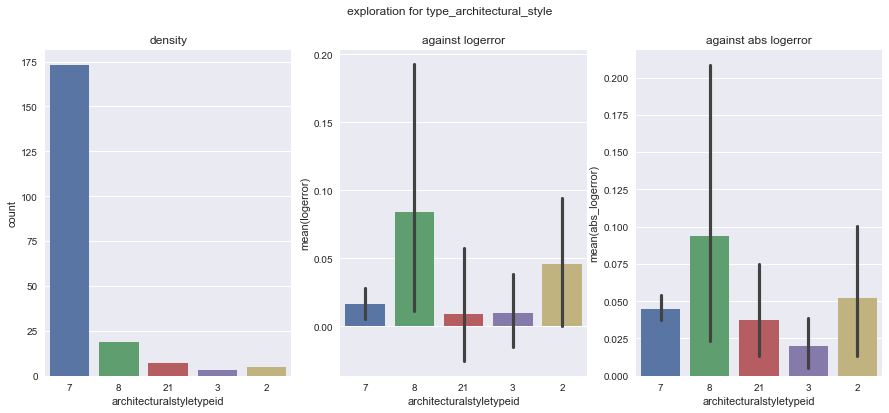

In [10]:
print('data type:' + str(prop_data['architecturalstyletypeid'].dtype))
cat_num_to_str('architecturalstyletypeid')
cat_feature_analysis('architecturalstyletypeid')
prop_missing, train_missing = missing_ratio('architecturalstyletypeid')
visual_analysis_cat('architecturalstyletypeid', 'type_architectural_style')

In [11]:
# missing rate too high
feature_info['architecturalstyletypeid'] = ['type_architectural_style', 'cat', 4, prop_missing, train_missing]

### basementsqft

Description:  Finished living area below or partially below ground level. So it is a numerical value

missing ratio prop: 0.9995
missing ratio train: 0.9994


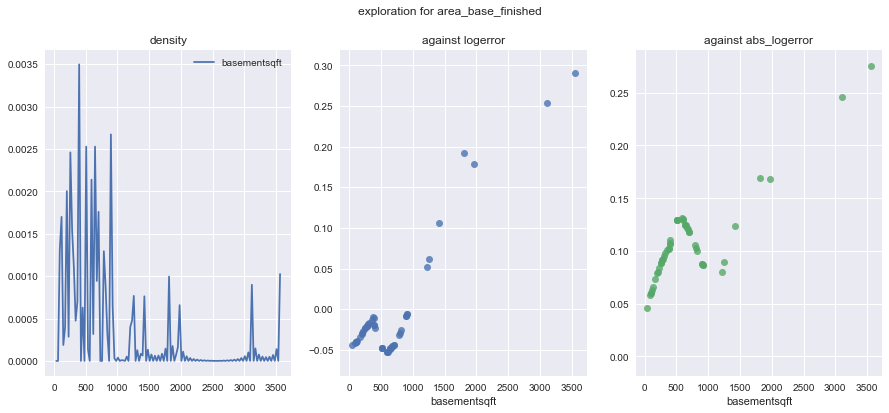

In [12]:
prop_missing, train_missing = missing_ratio('basementsqft')
visual_analysis_num('basementsqft', 'area_base_finished')

In [13]:
# missing rate is too high
feature_info['basementsqft'] = ['area_base_finished', 'num', 4, prop_missing, train_missing]

### bathroomcnt

Description: Number of bathrooms in home including fractional bathrooms. Also, according to FAQ, for some features there two versions, one from assessor and one from Zillow internally. This one is from assessor. For following feature exporation, those with post fix '_zillow' and 'assessor' are of this type.

missing ratio prop: 0.0010
missing ratio train: 0.0004


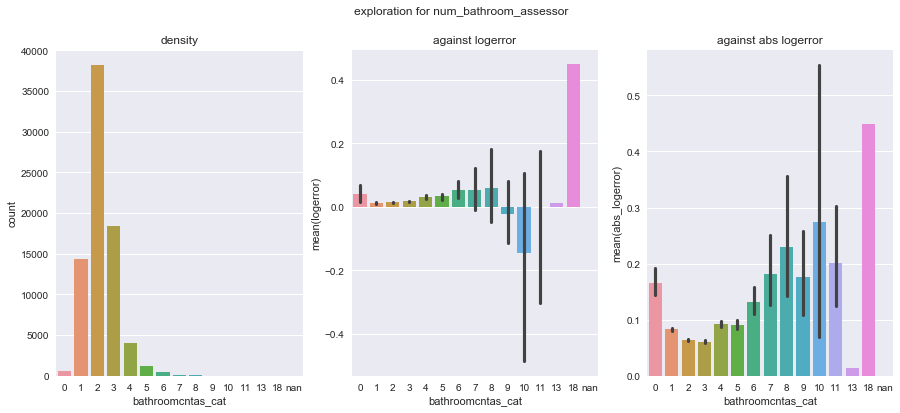

In [14]:
prop_missing, train_missing = missing_ratio('bathroomcnt')
visual_analysis_num_as_cat('bathroomcnt', 'num_bathroom_assessor')

In [15]:
# low missing rate, no obvious pattern in high density area
feature_info['bathroomcnt'] = ['num_bathroom_assessor', 'num', 2, prop_missing, train_missing]

### calculatedbathnbr

Description: Number of bathrooms in home including fractional bathroom.

missing ratio prop: 0.0392
missing ratio train: 0.0084


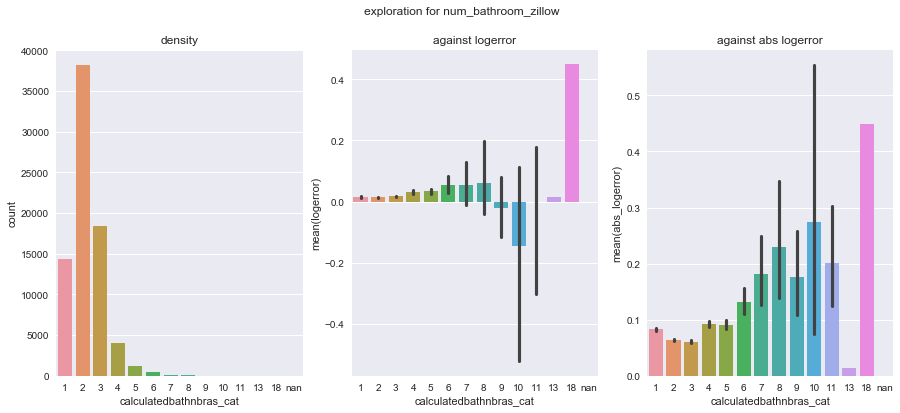

In [16]:
prop_missing, train_missing = missing_ratio('calculatedbathnbr')
visual_analysis_num_as_cat('calculatedbathnbr', 'num_bathroom_zillow')

In [17]:
# low missing rate, weak pattern in high density area, keep for now
feature_info['calculatedbathnbr'] = ['num_bathroom_zillow', 'num', 1, prop_missing, train_missing]

### bedroomcnt

Description:  Number of bedrooms in home.

missing ratio prop: 0.0010
missing ratio train: 0.0004


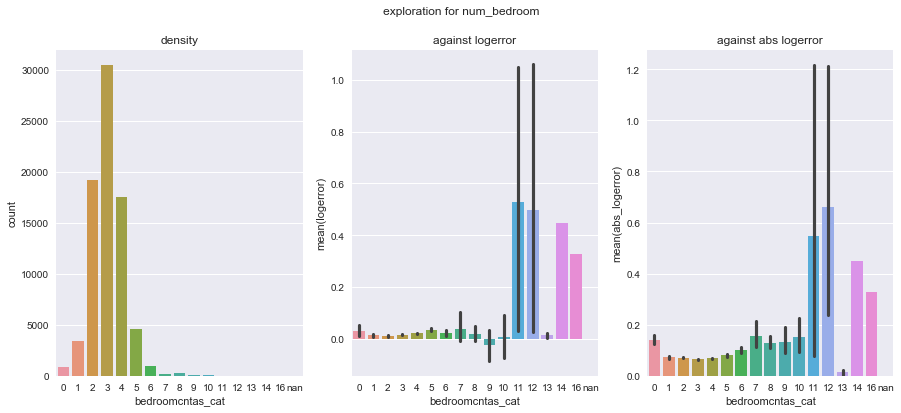

In [18]:
prop_missing, train_missing = missing_ratio('bedroomcnt')
visual_analysis_num_as_cat('bedroomcnt', 'num_bedroom')

In [19]:
# low missing rate, some pattern in high density area
feature_info['bedroomcnt'] = ['num_bedroom', 'num', 1, prop_missing, train_missing]

### buildingclasstypeid

Description: The building framing type (steel frame, wood frame, concrete/brick). Detailed description too long, put is as bullets.

- 1: Buildings having fireproofed structural steel frames carrying all wall, floor and roof loads. Wall, floor and roof structures are built of non-combustible materials.
- 2: Buildings having fireproofed reinforced concrete frames carrying all wall floor and roof loads which are all non-combustible.
- 3: Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.
- 4: Buildings having wood or wood and steel frames
- 5: Specialized buildings that do not fit in any of the above categories

Categorical, NaN should be real missing, rename to 'type_building_framing'

data type:float64
vals from train_data: 3, 4
n_vals from train_data: 2
vals in prop not in train: 1, 2, 5
n_vals in prop not in train: 3
ratio sample with val in prop not in train: 0.000068
missing ratio prop: 0.9957
missing ratio train: 0.9998


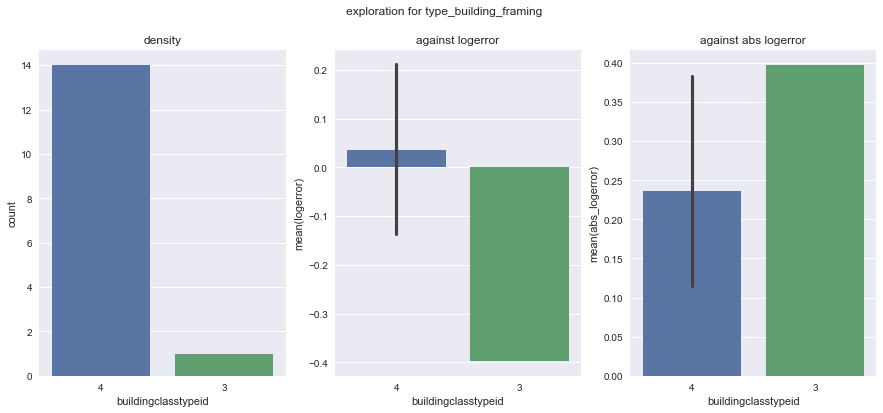

In [20]:
print('data type:' + str(prop_data['buildingclasstypeid'].dtype))
cat_num_to_str('buildingclasstypeid')
cat_feature_analysis('buildingclasstypeid')
prop_missing, train_missing = missing_ratio('buildingclasstypeid')
visual_analysis_cat('buildingclasstypeid', 'type_building_framing')

In [21]:
# too high missing rate drop
feature_info['buildingclasstypeid'] = ['type_building_framing', 'cat', 4, prop_missing, train_missing]

### buildingqualitytypeid

Overall assessment of condition of the building from best (lowest) to worst (highest). Although there is a 'typeid' in the name, it is not really categorical, rank between the values has actual meaning, take it as numerical

missing ratio prop: 0.3497
missing ratio train: 0.3582


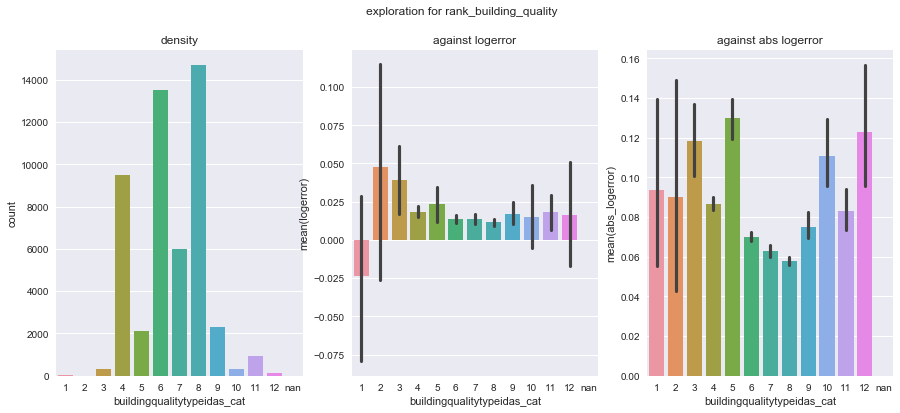

In [22]:
prop_missing, train_missing = missing_ratio('buildingqualitytypeid')
visual_analysis_num_as_cat('buildingqualitytypeid', 'rank_building_quality')

In [23]:
# missing rate is not high, but too weak pattern in high density area
feature_info['buildingqualitytypeid'] = ['rank_building_quality', 'num', 2, prop_missing, train_missing]

### decktypeid

Description: Type of deck (if any) present on parcel.

data type:float64
vals from train_data: 66
n_vals from train_data: 1
prop and train vals set consistent
missing ratio prop: 0.9942
missing ratio train: 0.9921


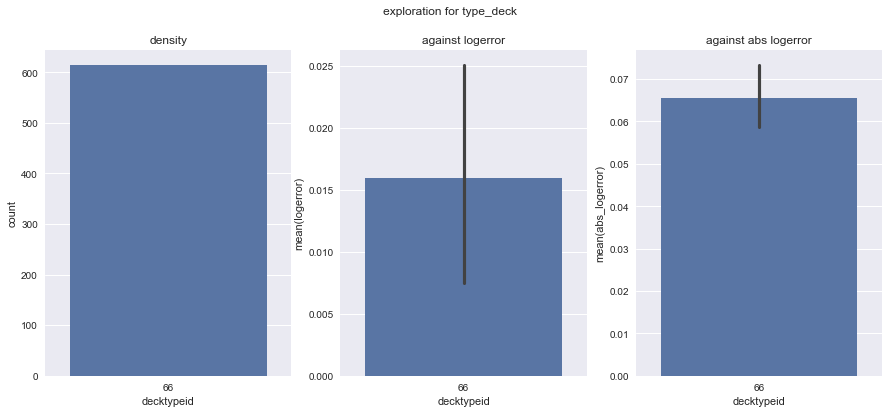

In [24]:
print('data type:' + str(prop_data['decktypeid'].dtype))
cat_num_to_str('decktypeid')
cat_feature_analysis('decktypeid')
prop_missing, train_missing = missing_ratio('decktypeid')
visual_analysis_cat('decktypeid', 'type_deck')

In [25]:
# missing rate too high, drop it
feature_info['decktypeid'] = ['type_deck', 'cat', 4, prop_missing, train_missing]

### finishedfloor1squarefeet

Description: Size of the finished living area on the first (entry) floor of the home.

missing ratio prop: 0.9317
missing ratio train: 0.9222


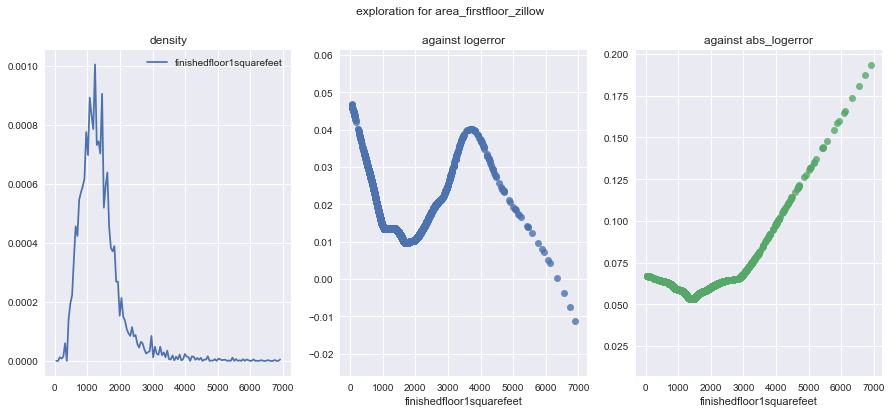

In [26]:
prop_missing, train_missing = missing_ratio('finishedfloor1squarefeet')
visual_analysis_num('finishedfloor1squarefeet', 'area_firstfloor_zillow')

In [27]:
# missing rate too high drop the feature.
feature_info['finishedfloor1squarefeet'] = ['area_firstfloor_zillow', 'num', 4, prop_missing, train_missing]

### calculatedfinishedsquarefeet

Description: Calculated total finished living area of the home.

missing ratio prop: 0.0151
missing ratio train: 0.0030


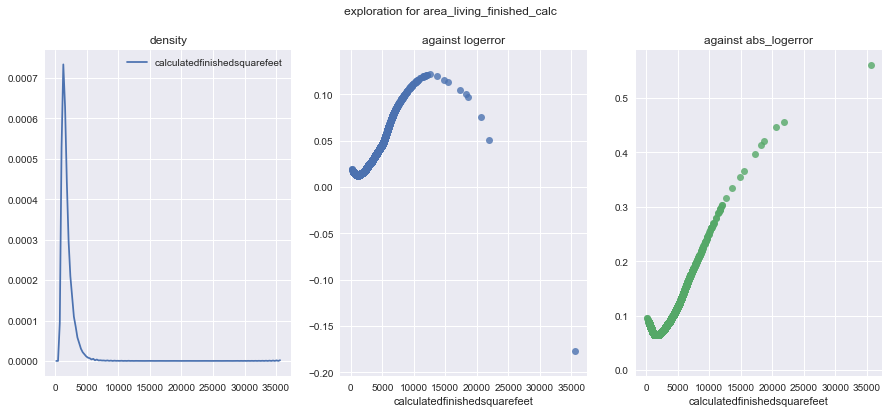

In [28]:
prop_missing, train_missing = missing_ratio('calculatedfinishedsquarefeet')
visual_analysis_num('calculatedfinishedsquarefeet', 'area_living_finished_calc')

In [29]:
# low missing rate, obvious pattern in high density area
feature_info['calculatedfinishedsquarefeet'] = ['area_living_finished_calc', 'num', 1, prop_missing, train_missing]

### finishedsquarefeet12

Description: Finished living area. A specific type of measuring of living area.

missing ratio prop: 0.0886
missing ratio train: 0.0475


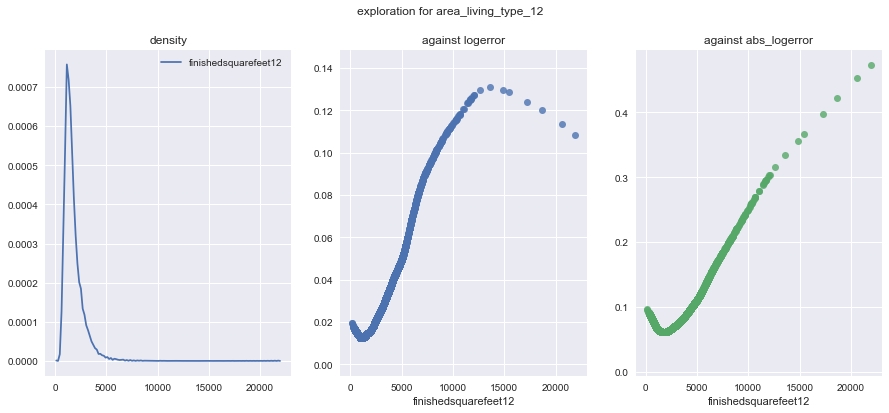

In [30]:
prop_missing, train_missing = missing_ratio('finishedsquarefeet12')
visual_analysis_num('finishedsquarefeet12', 'area_living_type_12')

In [31]:
# missing ratio is very low, pattern similar to area_living_finished_calc
feature_info['finishedsquarefeet12'] = ['area_living_type_12', 'num', 1, prop_missing, train_missing]

### finishedsquarefeet13

Description: Perimeter living area. A specific type of measuring of living area.

missing ratio prop: 0.9974
missing ratio train: 0.9995


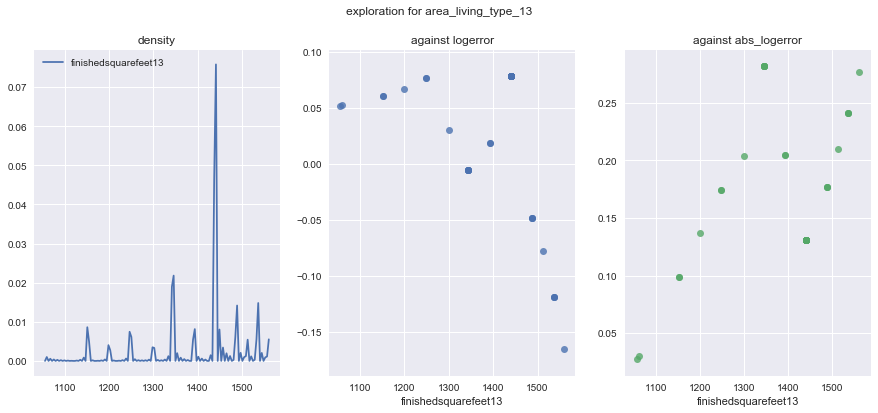

In [32]:
prop_missing, train_missing = missing_ratio('finishedsquarefeet13')
visual_analysis_num('finishedsquarefeet13', 'area_living_type_13')

In [33]:
# high missing rate, drop it.
feature_info['finishedsquarefeet13'] = ['area_living_type_13', 'num', 4, prop_missing, train_missing]

### finishedsquarefeet15

Description: Total area. A specific type of measuring of living area.

missing ratio prop: 0.9363
missing ratio train: 0.9610


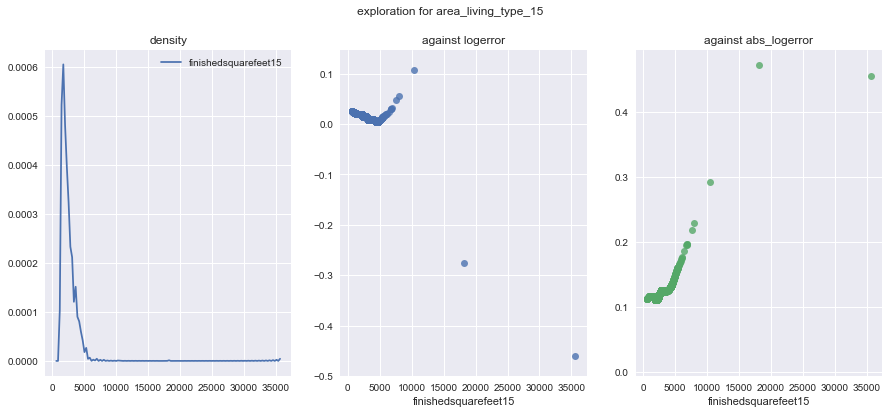

In [34]:
prop_missing, train_missing = missing_ratio('finishedsquarefeet15')
visual_analysis_num('finishedsquarefeet15', 'area_living_type_15')

In [35]:
# high missing rate, drop it.
feature_info['finishedsquarefeet15'] = ['area_living_type_15', 'num', 4, prop_missing, train_missing]

### finishedsquarefeet50

Description: Size of the finished living area on the first (entry) floor of the home. Another first floor living area.

missing ratio prop: 0.9317
missing ratio train: 0.9222


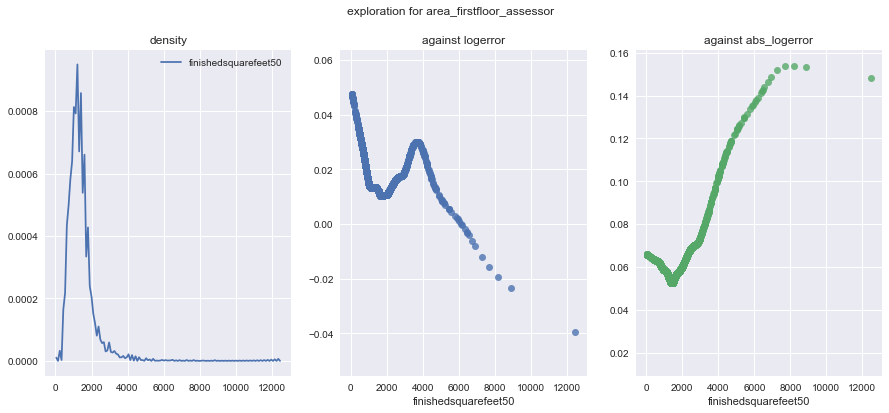

In [36]:
prop_missing, train_missing = missing_ratio('finishedsquarefeet50')
visual_analysis_num('finishedsquarefeet50', 'area_firstfloor_assessor')

In [37]:
# high missing rate, drop it.
feature_info['finishedsquarefeet50'] = ['area_firstfloor_assessor', 'num', 4, prop_missing, train_missing]

### finishedsquarefeet6

Description: Base unfinished and finished area. Specific type of living area.

missing ratio prop: 0.9928
missing ratio train: 0.9950


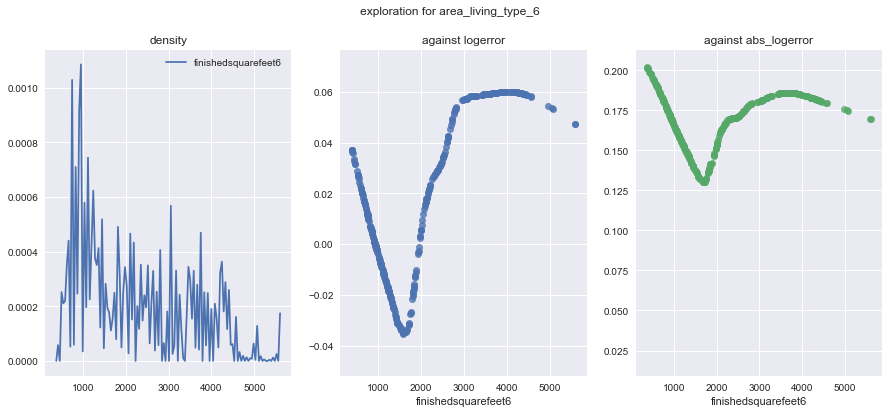

In [38]:
prop_missing, train_missing = missing_ratio('finishedsquarefeet6')
visual_analysis_num('finishedsquarefeet6', 'area_living_type_6')

In [39]:
# high missing rate, drop it.
feature_info['finishedsquarefeet6'] = ['area_living_type_6', 'num', 4, prop_missing, train_missing]

### fips

Description: eral Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details. It is categorical treated as numerical numbers.

data type:float64
vals from train_data: 6037, 6059, 6111
n_vals from train_data: 3
prop and train vals set consistent
missing ratio prop: 0.0010
missing ratio train: 0.0004


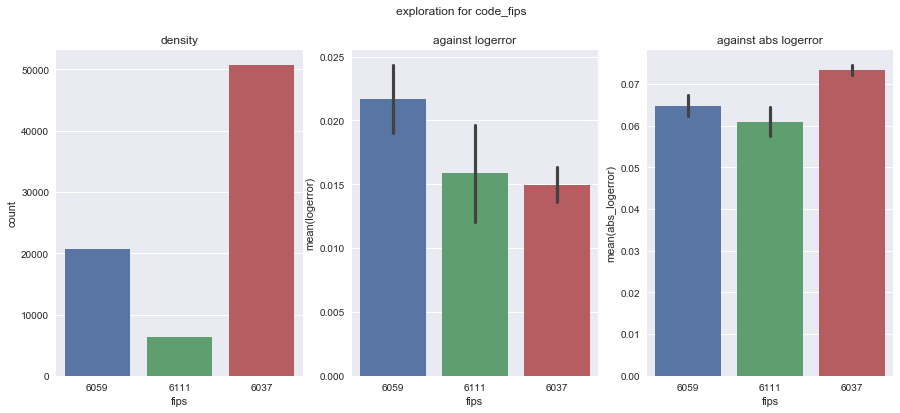

In [40]:
print('data type:' + str(prop_data['fips'].dtype))
cat_num_to_str('fips')
cat_feature_analysis('fips')
prop_missing, train_missing = missing_ratio('fips')
visual_analysis_cat('fips', 'code_fips')

In [41]:
# low missing rate, pattern area is not of high density, but can keep
feature_info['fips'] = ['code_fips', 'cat', 1, prop_missing, train_missing]

### fireplacecnt

Description: Number of fireplaces in a home (if any). '(if any)' means NaN shoud actually be handled as 0.

missing ratio prop: 0.8951
missing ratio train: 0.8932


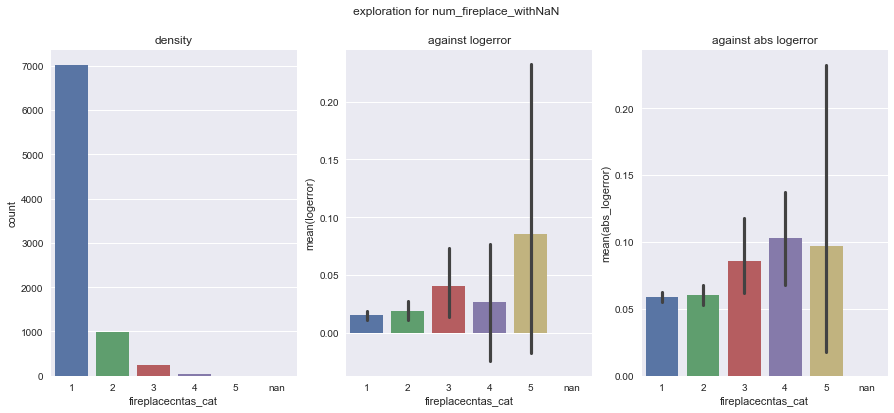

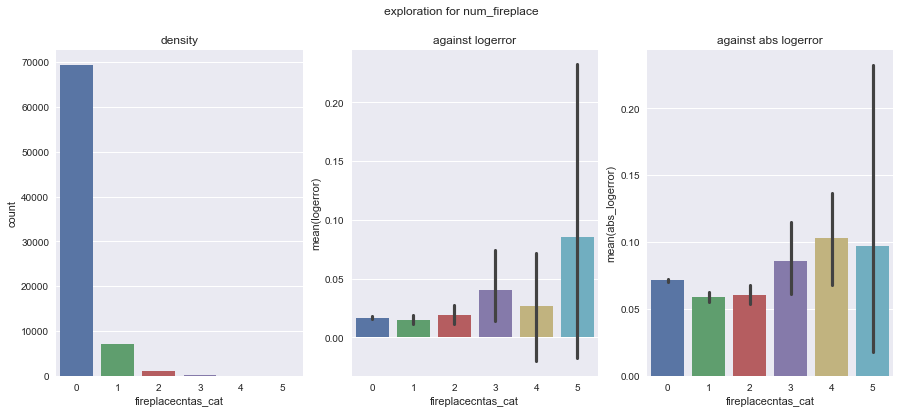

In [42]:
recover_col('fireplacecnt')
# checking missing ratio before impute
prop_missing, train_missing = missing_ratio('fireplacecnt')
visual_analysis_num_as_cat('fireplacecnt', 'num_fireplace_withNaN')
# impute NaN as 0 
prop_data['fireplacecnt'].fillna(0, inplace=True)
train_data['fireplacecnt'].fillna(0, inplace=True)
# no need to view missing ratio, directly add to feature
visual_analysis_num_as_cat('fireplacecnt', 'num_fireplace')

In [43]:
# missing rate is high, but there is good pattern at non missing area, however distribution is highly imbalanced
feature_info['fireplacecnt'] = ['num_fireplace', 'num', 2, prop_missing, train_missing]

### fullbathcnt

Description: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home. Meanwhile, we have 'bath room count' feature, which had no missing value. Below analysis shows that NaN full bathroom are not all having 0 bathroom, let's impute it this way: 1, n_bathroom is fraction, take floor; 2, n_bathroom is int, reduce by 1. And rename to 'num_fullbath'.

min num_full_bath in train: 1
range of num_bath for NaN fullbath: min = 0, max = 5, num_nan= 34
missing ratio prop: 0.0392
missing ratio train: 0.0084


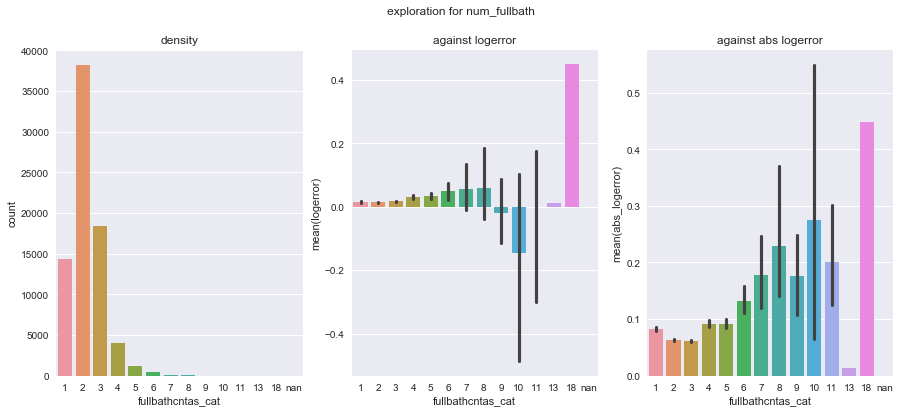

In [45]:
import math
recover_col('fullbathcnt')
print('min num_full_bath in train: %d' % np.min(train_data['fullbathcnt'].dropna()))
bathroomcnt_subset = train_data['bathroomcnt'].loc[train_data.index.values[train_data['fullbathcnt'].isnull()]]
bathroomcnt_subset_n_nan = np.sum(bathroomcnt_subset.isnull())
bathroomcnt_subset_nonan = bathroomcnt_subset.dropna()
bathroomcnt_subset_nonan_max = bathroomcnt_subset_nonan.max()
bathroomcnt_subset_nonan_min = bathroomcnt_subset_nonan.min()
print('range of num_bath for NaN fullbath: min = %d, max = %d, num_nan= %d' % (bathroomcnt_subset_nonan_min, bathroomcnt_subset_nonan_max, bathroomcnt_subset_n_nan))

# special NaN impute:
def nan_impute_fullbathcnt(data):
    null_idx = data.index[data['fullbathcnt'].isnull()]
    fill_val = data['bathroomcnt'][null_idx].copy()
    fill_val_raw = fill_val.copy()
    fill_val_raw_floor = fill_val_raw.apply(math.floor)
    int_idx = np.abs(fill_val_raw.values - fill_val_raw_floor.values) < 1e-12
    fill_val[int_idx] = np.maximum(fill_val_raw[int_idx] - 1, 0)
    fill_val[~int_idx] = fill_val_raw_floor[~int_idx]
    data.loc[null_idx, 'fullbathcnt'] = fill_val
    return data

prop_missing, train_missing = missing_ratio('fullbathcnt')
col_fill_na(prop_data, 'bathroomcnt', 'mode')
# prop_data = nan_impute_fullbathcnt(prop_data)
# train_data = nan_impute_fullbathcnt(train_data)
visual_analysis_num_as_cat('fullbathcnt', 'num_fullbath')

In [46]:
# low original missing rate, pattern around high density area
feature_info['fullbathcnt'] = ['num_fullbath', 'num', 1, prop_missing, train_missing]

### garagecarcnt

Description:  Total number of garages on the lot including an attached garage. Have 0 in data, leave NaN as it is

missing ratio prop: 0.7015
missing ratio train: 0.6712


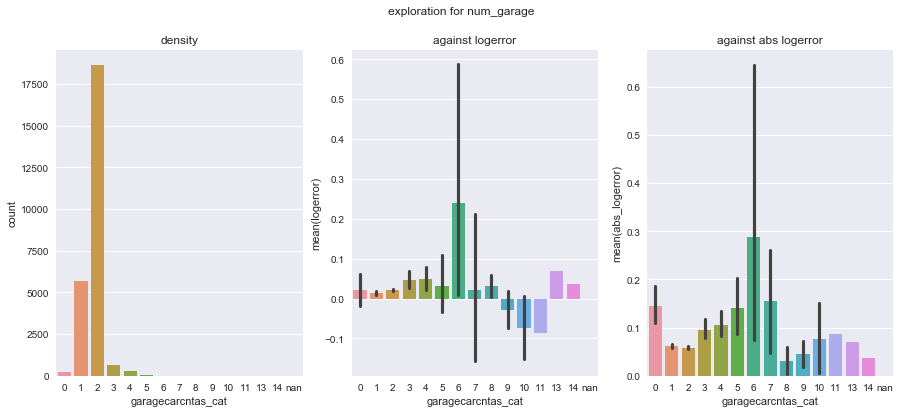

In [47]:
prop_missing, train_missing = missing_ratio('garagecarcnt')
visual_analysis_num_as_cat('garagecarcnt', 'num_garage')

In [48]:
# missing rate not low, also, no pattern in high density area
feature_info['garagecarcnt'] = ['num_garage', 'num', 2, prop_missing, train_missing]

### garagetotalsqft

Description: Total number of square feet of all garages on lot including an attached garage. A quick view on the data looks strange, besides NaN, we have 0 values for this field, while most of them do not corrsponds to 0 count. Let's mark those zero area with non-zero count as NaN.

missing ratio prop: 0.7640
missing ratio train: 0.7674


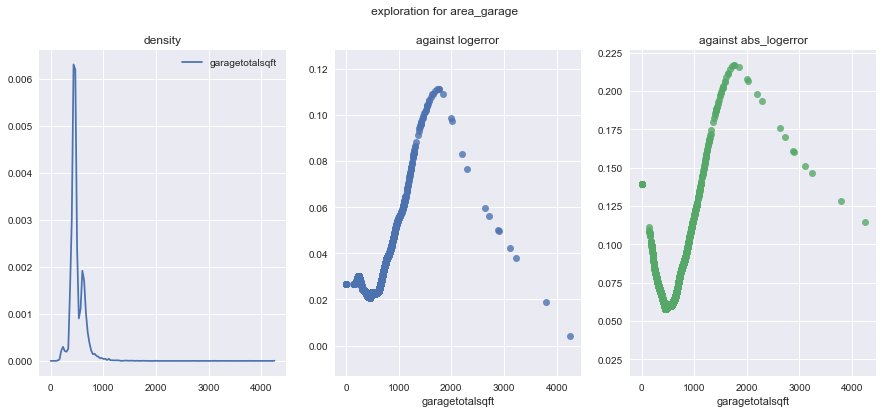

In [49]:
def zero_impute_area_garage(data):
    target_idx = data.index[np.abs(data['garagetotalsqft'] - 0) < 1e-12]
    nan_idx = target_idx[data.loc[target_idx, 'garagecarcnt'] > 0]
    data.loc[nan_idx, 'garagetotalsqft'] = np.nan

zero_impute_area_garage(prop_data)
zero_impute_area_garage(train_data)

prop_missing, train_missing = missing_ratio('garagetotalsqft')
visual_analysis_num('garagetotalsqft', 'area_garage')

In [50]:
# missing ratio looks high. but there looks pattern in high density area
feature_info['garagetotalsqft'] = ['area_garage', 'num', 2, prop_missing, train_missing]

### hashottuborspa

Description:  Does the home have a hot tub or spa. This is a bool, and value only has TRUE and NaN, so seems reasonable to put NaN as False and use this feature as category.

n TRUE samples: 1539


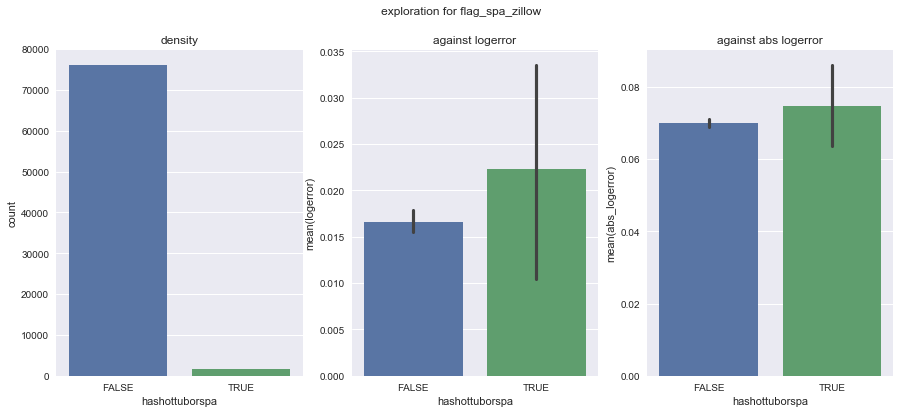

In [51]:
recover_col('hashottuborspa')
mark_flag_col('hashottuborspa')
# no missing rate
visual_analysis_cat('hashottuborspa', 'flag_spa_zillow')
print('n TRUE samples: %d' % np.sum(train_data['hashottuborspa'] == 'TRUE'))

In [52]:
# quite imbalanced ditribution, but good pattern between groups, num true = 2365, good enough to form a leave
feature_info['hashottuborspa'] = ['flag_spa_zillow', 'cat', 1, 0.0, 0.0]

### heatingorsystemtypeid

Description: Type of home heating system. Details of each type:

| Type ID  | Description  |
|----------|---|
|1	|Baseboard|
|2	|Central|
|3	|Coal|
|4	|Convection|
|5	|Electric|
|6	|Forced air|
|7	|Floor/Wall|
|8	|Gas|
|9	|Geo Thermal|
|10	|Gravity|
|11	|Heat Pump|
|12	|Hot Water|
|13	|None|
|14	|Other|
|15	|Oil|
|16	|Partial|
|17	|Propane|
|18	|Radiant|
|19	|Steam|
|20	|Solar|
|21	|Space/Suspended|
|22	|Vent|
|23	|Wood Burning|
|24	|Yes|
|25	|Zone|

Since None is already in there, should take NaN as true missing. 

data type:float64
vals from train_data: 1, 10, 11, 13, 18, 2, 20, 24, 6, 7
n_vals from train_data: 10
vals in prop not in train: 12, 14, 19, 21
n_vals in prop not in train: 4
ratio sample with val in prop not in train: 0.000023
missing ratio prop: 0.3739
missing ratio train: 0.3613


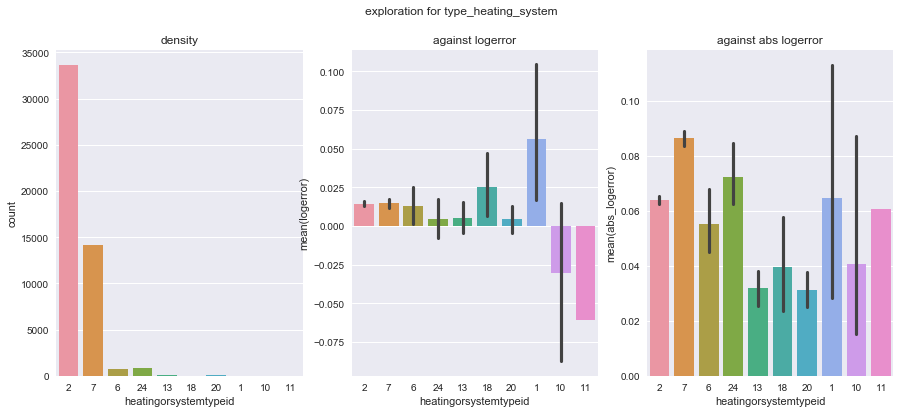

In [53]:
print('data type:' + str(prop_data['heatingorsystemtypeid'].dtype))
cat_num_to_str('heatingorsystemtypeid')
cat_feature_analysis('heatingorsystemtypeid')
prop_missing, train_missing = missing_ratio('heatingorsystemtypeid')
visual_analysis_cat('heatingorsystemtypeid', 'type_heating_system')

In [54]:
# missing rate is not too high, very good discrimination power.
feature_info['heatingorsystemtypeid'] = ['type_heating_system', 'cat', 1, prop_missing, train_missing]

### latitude

Description: Latitude of the middle of the parcel multiplied by 10e6. Typical numerical feature. Sure to include in model.

missing ratio prop: 0.0010
missing ratio train: 0.0004


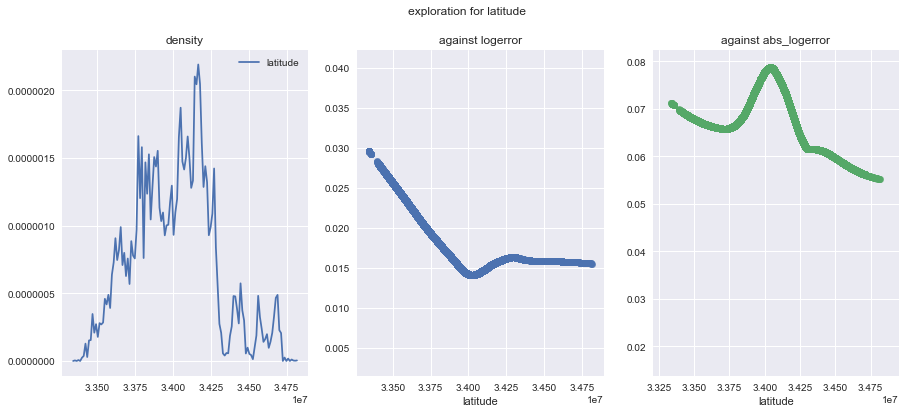

In [55]:
prop_missing, train_missing = missing_ratio('latitude')
visual_analysis_num('latitude', 'latitude')

In [56]:
# no missing, very good discrimination power.
feature_info['latitude'] = ['latitude', 'num', 1, prop_missing, train_missing]

### longitude

Description: Longitude of the middle of the parcel multiplied by 10e6. Typical numerical feature. Sure to include in model

missing ratio prop: 0.0010
missing ratio train: 0.0004


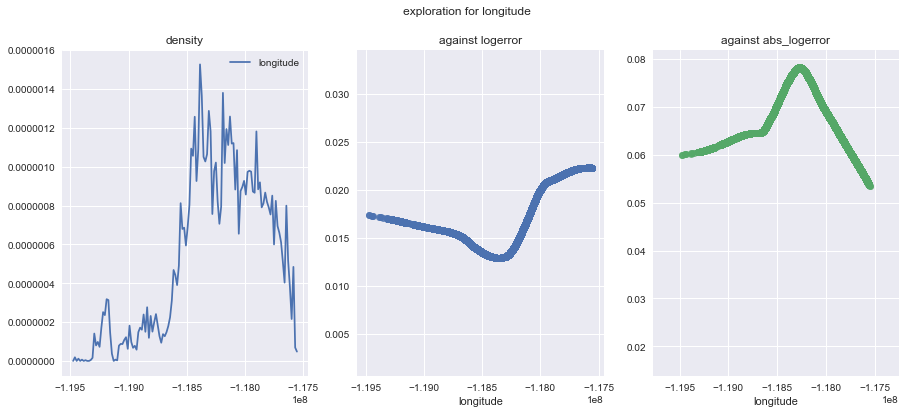

In [57]:
prop_missing, train_missing = missing_ratio('longitude')
visual_analysis_num('longitude', 'longitude')

In [58]:
# no missing, very good discrimination power.
feature_info['longitude'] = ['longitude', 'num', 1, prop_missing, train_missing]

### lotsizesquarefeet

Description: Area of the lot in square feet.

missing ratio prop: 0.0914
missing ratio train: 0.1068


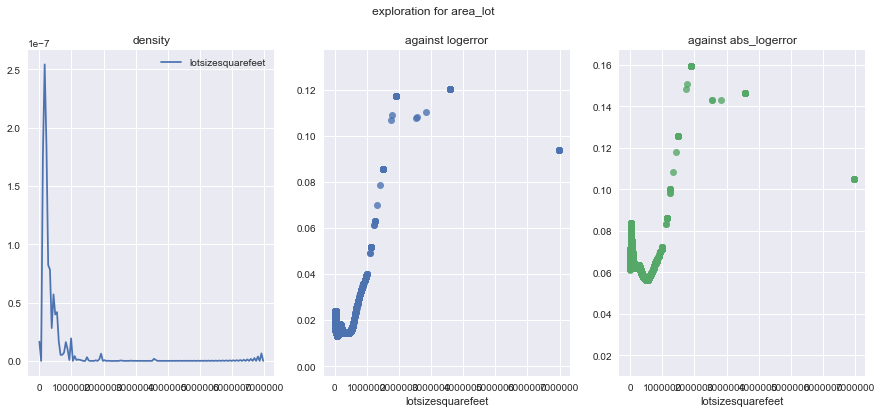

In [59]:
prop_missing, train_missing = missing_ratio('lotsizesquarefeet')
visual_analysis_num('lotsizesquarefeet', 'area_lot')

In [60]:
# low missing rate, but density is too concentrated, looks pattern there, keep it as class 1
feature_info['lotsizesquarefeet'] = ['area_lot', 'num', 1, prop_missing, train_missing]

### poolcnt

Description: Number of pools on the lot (if any). From train data, the recorded values are either 1 or NaN. So make if a bool categorical variable, with >=1 -> TRUE and FALSE otherwise. Apply the same to prop data. rename it to 'flag_pool'.

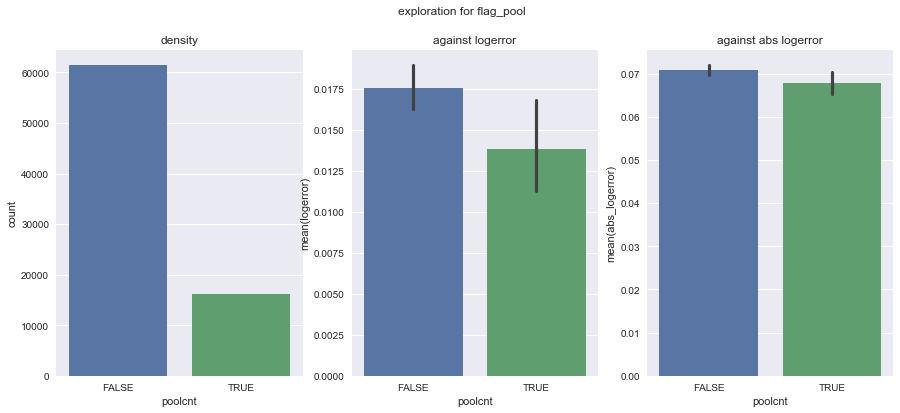

In [61]:
mark_flag_col('poolcnt')
visual_analysis_cat('poolcnt', 'flag_pool')

In [62]:
# very ideal discrimination power
feature_info['poolcnt'] = ['flag_pool', 'cat', 1, 0.0, 0.0]

### poolsizesum

Description: Total square footage of all pools on property. Numerical variable. Since we have marked number pool as existing or not, then flag_pool == FALSE set size to 0. leave others as nan or value given.

missing ratio prop: 0.1714
missing ratio train: 0.1972


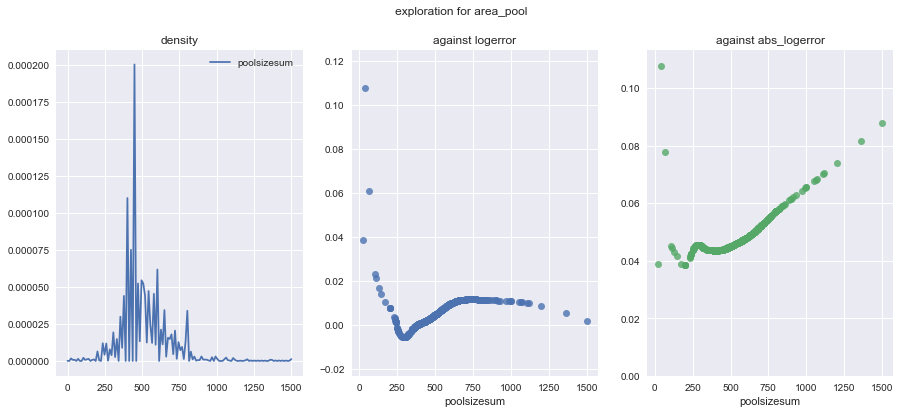

In [63]:
prop_data.loc[prop_data.index[prop_data['poolcnt'] == 'FALSE'], 'poolsizesum'] = 0
train_data.loc[train_data.index[train_data['poolcnt'] == 'FALSE'], 'poolsizesum'] = 0
prop_missing, train_missing = missing_ratio('poolsizesum')
visual_analysis_num('poolsizesum', 'area_pool')

In [64]:
# missing is no high, but pattern is too weak. However pattern with abs_log error is good
feature_info['poolsizesum'] = ['area_pool', 'num', 2, prop_missing, train_missing]

### pooltypeid10

Description: Spa or Hot Tub. Seems to be a property of pool, but none of the has-value sample shows up with a TRUE pool count. Directly take a look at missing rate and patterns. It only has 1 or NaN, mark nan as FALSE. let's take a look at the pattern.

n consistent pool_type_10 and pool cnt: 0
number TRUE: 465


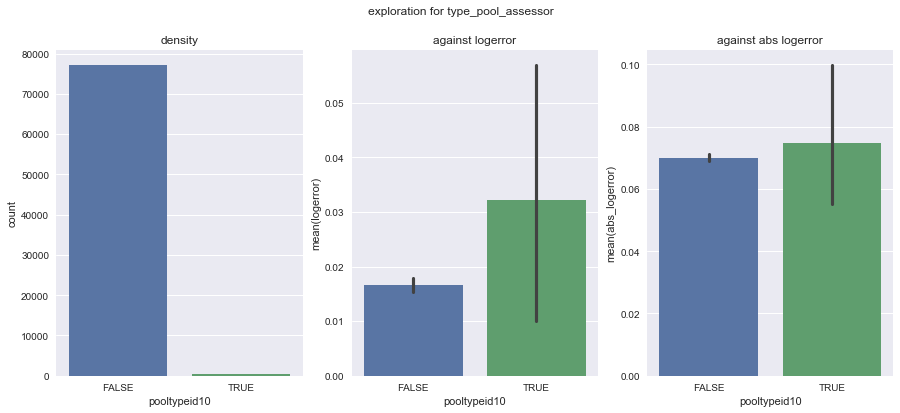

In [65]:
print('n consistent pool_type_10 and pool cnt: %d' % np.sum(np.logical_and(train_data['poolcnt'] == 'TRUE', train_data['pooltypeid10'] == 1)))
mark_flag_col('pooltypeid10')
visual_analysis_cat('pooltypeid10', 'type_pool_assessor')
print('number TRUE: %d' % (np.sum(train_data['pooltypeid10'] == 'TRUE')))

In [66]:
#Groups too much imbalanced, Together considering the strange behavior of the feature, for sure NOT to use it for modeling
feature_info['pooltypeid10'] = ['type_pool_assessor', 'cat', 4, 0.0, 0.0]

### pooltypeid2

Description: Pool with Spa/Hot Tub. So it describs details of pools. Together with next one:

### pooltypeid7

Description: Pool without hot tub.

Looks these two should be complementary and related to flag_pool.

In [67]:
# first mark names and transform features
mark_flag_col('pooltypeid2')
mark_flag_col('pooltypeid7')
# show flag_pool_type2 OR flag_pool_type7 == flag_pool, and flag_pool_type2 AND flag_pool_type7 == 0
flag_type2 = train_data['pooltypeid2'] == 'TRUE'
flag_type7 = train_data['pooltypeid7'] == 'TRUE'
flag_pool = train_data['poolcnt'] == 'TRUE'
print('num type2 OR type7 != pool: %d <expect 0>' % np.sum(np.logical_xor(np.logical_or(flag_type2, flag_type7), flag_pool)))
print('num type2 AND type7: %d <expect 0>' % np.sum(np.logical_and(flag_type2, flag_type7)))
print('number TRUE type2: %d' % (np.sum(train_data['pooltypeid2'] == 'TRUE'))) 
print('number TRUE type7: %d' % (np.sum(train_data['pooltypeid7'] == 'TRUE'))) 

num type2 OR type7 != pool: 21 <expect 0>
num type2 AND type7: 0 <expect 0>
number TRUE type2: 1074
number TRUE type7: 15079


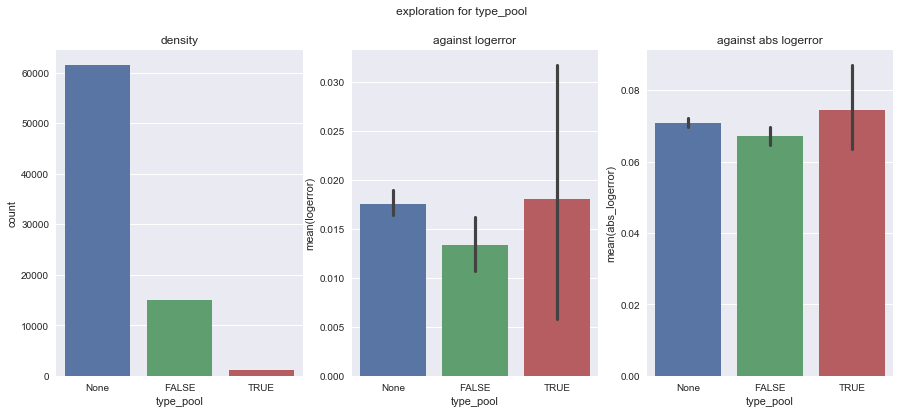

In [68]:
# It means we only need to keep one as feature, but need to make it as a new one, marking NaN as a new categroy.
def make_pool_type(data):
    data['type_pool'] = 'None'
    data.loc[data.index[data['pooltypeid2'] == 'TRUE'], 'type_pool'] = 'TRUE'
    data.loc[data.index[data['pooltypeid7'] == 'TRUE'], 'type_pool'] = 'FALSE'

make_pool_type(prop_data)
make_pool_type(train_data)
visual_analysis_cat('type_pool', 'type_pool')

In [69]:
# size of type 2 is good enough, and there is additional pattern between 2 and 7, keep this one as the good feature
feature_info['poolcnt'] = ['flag_pool', 'cat', 4, 0.0, 0.0]
feature_info['pooltypeid2'] = ['flag_pool_type_2', 'cat', 4, 0.0, 0.0]
feature_info['pooltypeid7'] = ['flag_pool_type_7', 'cat', 4, 0.0, 0.0]
feature_info['type_pool'] = ['type_pool', 'cat', 1, 0.0, 0.0]

### propertycountylandusecode

Description: County land use code i.e. it's zoning at the county level. It is categorical, but has frightening 78 categories.

In [70]:
print('n categories: %d' % len(train_data['propertycountylandusecode'].unique()))
prop_missing, train_missing = missing_ratio('propertycountylandusecode')

n categories: 76
missing ratio prop: 0.0010
missing ratio train: 0.0004


In [71]:
# no missing, but number of category is too high, need to find a way to make it usable
feature_info['propertycountylandusecode'] = ['code_county_landuse', 'cat', 3, prop_missing, train_missing]

### propertylandusetypeid

Description: Type of land use the property is zoned for. Categorical again, but appeared as numerical.

data type:float64
vals from train_data: 246, 247, 248, 260, 261, 263, 264, 265, 266, 267, 269, 275, 31
n_vals from train_data: 13
vals in prop not in train: 270, 279, 47
n_vals in prop not in train: 3
ratio sample with val in prop not in train: 0.001479
missing ratio prop: 0.0010
missing ratio train: 0.0004


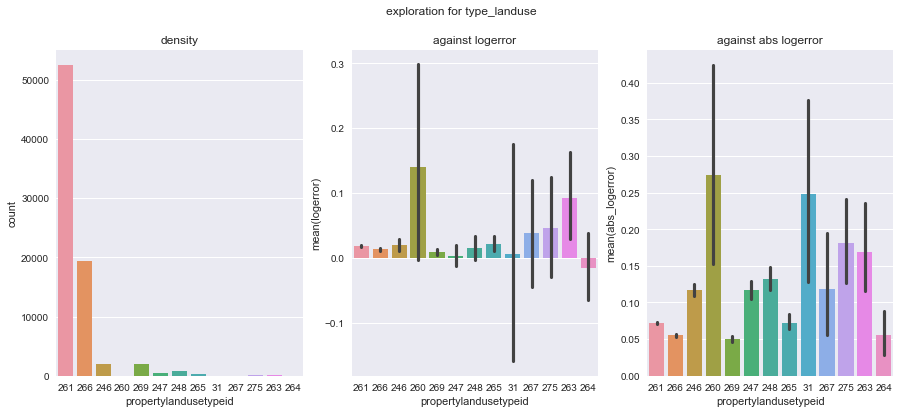

In [72]:
print('data type:' + str(prop_data['propertylandusetypeid'].dtype))
cat_num_to_str('propertylandusetypeid')
cat_feature_analysis('propertylandusetypeid')
prop_missing, train_missing = missing_ratio('propertylandusetypeid')
visual_analysis_cat('propertylandusetypeid', 'type_landuse')

In [73]:
# no missing, good discrimination power on high density area, note the high variance
feature_info['propertylandusetypeid'] = ['type_landuse', 'cat', 1, prop_missing, train_missing]

### propertyzoningdesc

Description: Description of the allowed land uses (zoning) for that property. Categorical, with 1997 categories, let's skip it.

In [74]:
print('n categories: %d' % len(train_data['propertyzoningdesc'].unique()))
prop_missing, train_missing = missing_ratio('propertyzoningdesc')

n categories: 1908
missing ratio prop: 0.3359
missing ratio train: 0.3496


In [75]:
# too many categories, leave it for later
feature_info['propertyzoningdesc'] = ['str_zoning_desc', 'cat', 3, prop_missing, train_missing]

### rawcensustractandblock

Description: Census tract and block ID combined - also contains blockgroup assignment by extension. It is a combination of categorical information, but presented as float numerical:
1, first 4 digits is FIPS, just drop it.
2, next 6 digits, splitted by a dot, it census tract.
3, last 4 digits I assume it is block ID.
Let's create new features from it, as census_raw and block_raw.

In [76]:
prop_missing, train_missing = missing_ratio('rawcensustractandblock')
print(train_data['rawcensustractandblock'].dtype)
def raw_census_info_split(data):
    data['temp'] = data['rawcensustractandblock'].apply(lambda x: str(round(x * 1000000)) if not np.isnan(x) else 'nan')
    data['temp'] = data['temp'].astype('O')
    data['raw_census'] = data['temp'].apply(lambda x: x[4:10] if not x == 'nan' else np.nan)
    data['raw_block'] = data['temp'].apply(lambda x: x[10:] if not x == 'nan' else np.nan)
    data.drop('temp', axis=1, inplace=True)
raw_census_info_split(prop_data)
raw_census_info_split(train_data)
print('n categories raw_census: %d' % len(train_data['raw_census'].unique()))
print('n categories raw block: %d' % len(train_data['raw_block'].unique()))

missing ratio prop: 0.0010
missing ratio train: 0.0004
float64
n categories raw_census: 2990
n categories raw block: 657


In [77]:
# but need to impute for prop_data
feature_info['rawcensustractandblock'] = ['raw_census_block', 'none', 4, prop_missing, train_missing]
feature_info['raw_census'] = ['raw_census', 'cat', 3, prop_missing, train_missing]
feature_info['raw_block'] = ['raw_block', 'cat', 3, prop_missing, train_missing]

### regionidcity

Description: City in which the property is located (if any). The 'if any' here look strange, property has to lay in a city, so missing is NaN. It is a number like string, so should be transformed to categorical.

In [78]:
print('n categories regionidcity: %d' % len(train_data['regionidcity'].unique()))
prop_missing, train_missing = missing_ratio('regionidcity')

n categories regionidcity: 176
missing ratio prop: 0.0208
missing ratio train: 0.0194


In [79]:
# number of categories is too high
feature_info['regionidcity'] = ['code_city', 'cat', 3, prop_missing, train_missing]

### regionidcounty

Description: County in which the property is located.

In [80]:
print('n categories regionidcounty: %d' % len(train_data['regionidcounty'].unique()))
prop_missing, train_missing = missing_ratio('regionidcounty')
cat_num_to_str('fips')
cat_num_to_str('regionidcounty')
# look to be completely overlapping with fips
def map_fips(x):
    if x == '6037':
        return '3101'
    elif x == '6059':
        return '1286'
    else:
        return '2061'
train_data['mapped_fips'] = train_data['fips'].apply(map_fips)
print('n diff mapped fips vs. county code: %d' % np.sum(train_data['mapped_fips'] != train_data['regionidcounty']))

n categories regionidcounty: 4
missing ratio prop: 0.0010
missing ratio train: 0.0004
n diff mapped fips vs. county code: 34


In [81]:
# we already kept fips
feature_info['regionidcounty'] = ['code_county', 'cat', 4, prop_missing, train_missing]

### regionidneighborhood

Description: Neighborhood in which the property is located.

In [82]:
print('n categories regionidneighborhood: %d' % len(train_data['regionidneighborhood'].unique()))
prop_missing, train_missing = missing_ratio('regionidneighborhood')

n categories regionidneighborhood: 481
missing ratio prop: 0.6125
missing ratio train: 0.6009


In [83]:
feature_info['regionidneighborhood'] = ['code_neighborhood', 'cat', 3, prop_missing, train_missing]

### regionidzip

Description:  Zip code in which the property is located. code_zip

In [84]:
print('n categories regionidzip: %d' % len(train_data['regionidzip'].unique()))
prop_missing, train_missing = missing_ratio('regionidzip')

n categories regionidzip: 390
missing ratio prop: 0.0043
missing ratio train: 0.0011


In [85]:
feature_info['regionidzip'] = ['code_zip', 'cat', 3, prop_missing, train_missing]

### roomcnt

Description: Total number of rooms in the principal residence

missing ratio prop: 0.0010
missing ratio train: 0.0004


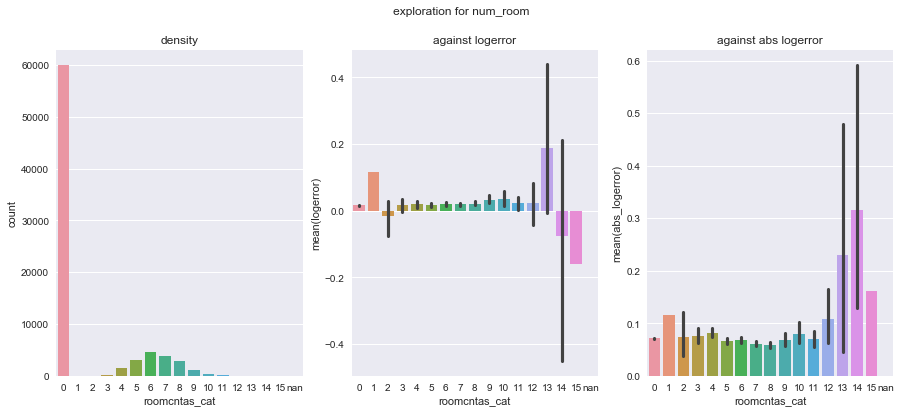

In [86]:
prop_missing, train_missing = missing_ratio('roomcnt')
visual_analysis_num_as_cat('roomcnt', 'num_room')

In [87]:
# high density area weak difference
feature_info['roomcnt'] = ['num_room', 'num', 2, prop_missing, train_missing]

### storytypeid

Description: Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.).  See tab for details. Details includes 35 types, I am not going to list all of them here.

data type:float64
vals from train_data: 7
n_vals from train_data: 1
prop and train vals set consistent
missing ratio prop: 0.9995
missing ratio train: 0.9994


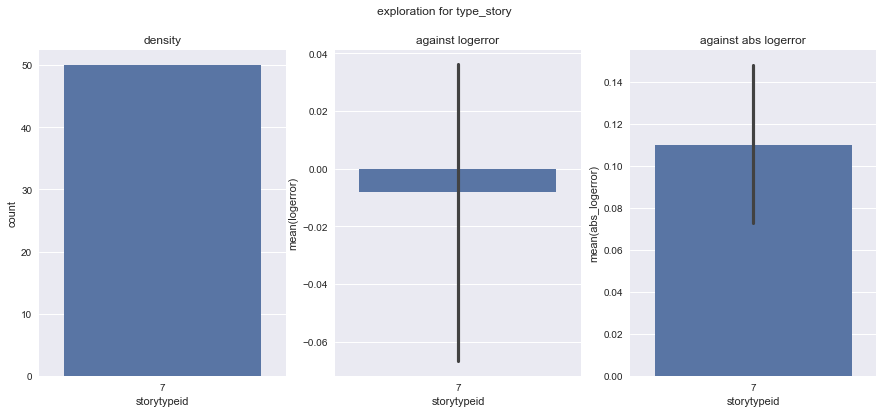

In [88]:
print('data type:' + str(prop_data['storytypeid'].dtype))
cat_num_to_str('storytypeid')
cat_feature_analysis('storytypeid')
prop_missing, train_missing = missing_ratio('storytypeid')
visual_analysis_cat('storytypeid', 'type_story')

In [89]:
# missing rate too high
feature_info['storytypeid'] = ['type_story', 'cat', 4, prop_missing, train_missing]

### threequarterbathnbr

Description: Number of 3/4 bathrooms in house (shower + sink + toilet). Min value is 1, use 0 for NaN.

missing ratio prop: 0.8940
missing ratio train: 0.8698


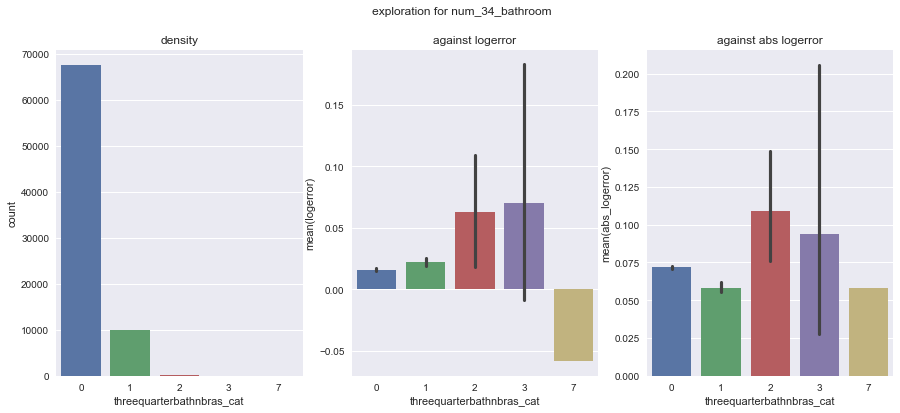

In [90]:
prop_missing, train_missing = missing_ratio('threequarterbathnbr')
col_fill_na(train_data, 'threequarterbathnbr', '0')
visual_analysis_num_as_cat('threequarterbathnbr', 'num_34_bathroom')

In [91]:
# high missing rate, and no difference in high density area
feature_info['threequarterbathnbr'] = ['num_34_bathroom', 'num', 4, prop_missing, train_missing]

### typeconstructiontypeid

Description: What type of construction material was used to construct the home. Categorical, 18 groups in total. It includes 'Other', so NaN can be treated as missing. I am not going to list all the detailed description here.

data type:float64
vals from train_data: 10, 13, 4, 6
n_vals from train_data: 4
vals in prop not in train: 11
n_vals in prop not in train: 1
ratio sample with val in prop not in train: 0.000000
missing ratio prop: 0.9977
missing ratio train: 0.9971


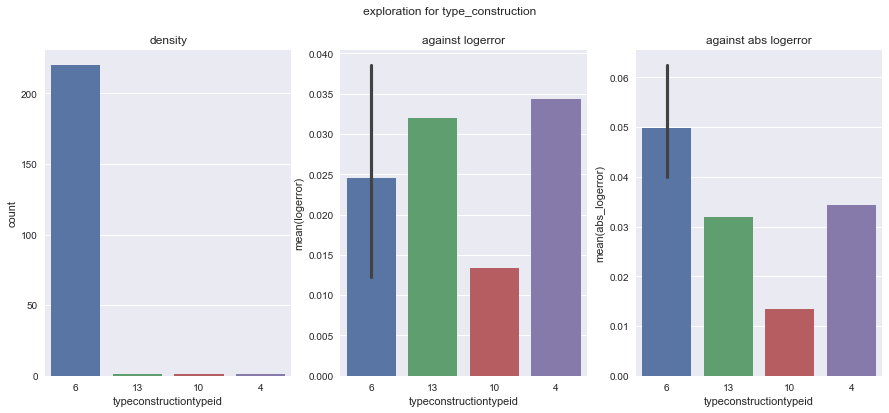

In [92]:
print('data type:' + str(prop_data['typeconstructiontypeid'].dtype))
cat_num_to_str('typeconstructiontypeid')
cat_feature_analysis('typeconstructiontypeid')
prop_missing, train_missing = missing_ratio('typeconstructiontypeid')
visual_analysis_cat('typeconstructiontypeid', 'type_construction')

In [93]:
# missing rate too high.
feature_info['typeconstructiontypeid'] = ['type_construction', 'cat', 4, prop_missing, train_missing]

### unitcnt

Description: Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...). 

missing ratio prop: 0.3364
missing ratio train: 0.3467


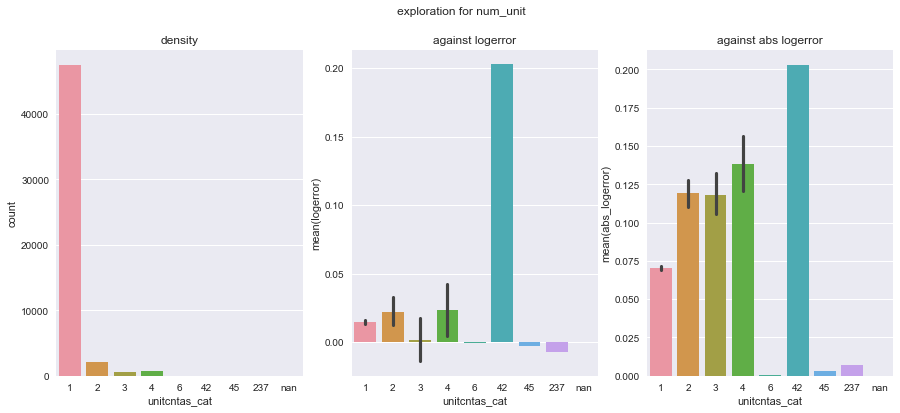

In [94]:
prop_missing, train_missing = missing_ratio('unitcnt')
visual_analysis_num_as_cat('unitcnt', 'num_unit')

In [95]:
# missing rate is OK, distribution is quite umbalanced. Need some engineering to make it workable
feature_info['unitcnt'] = ['num_unit', 'num', 2, prop_missing, train_missing]

### yardbuildingsqft17

Description: Patio in  yard.

missing ratio prop: 0.9727
missing ratio train: 0.9692


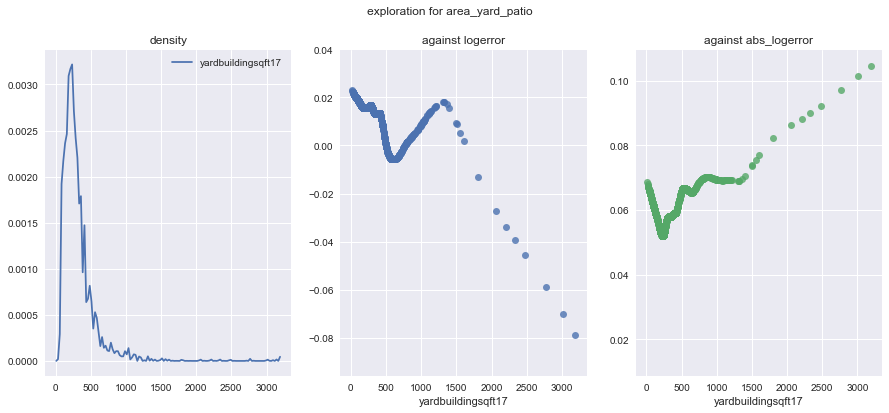

In [96]:
prop_missing, train_missing = missing_ratio('yardbuildingsqft17')
visual_analysis_num('yardbuildingsqft17', 'area_yard_patio')

In [97]:
# missing rate too high for training
feature_info['yardbuildingsqft17'] = ['area_yard_patio', 'num', 4, prop_missing, train_missing]

### yardbuildingsqft26

Description: Storage shed/building in yard.

missing ratio prop: 0.9991
missing ratio train: 0.9991


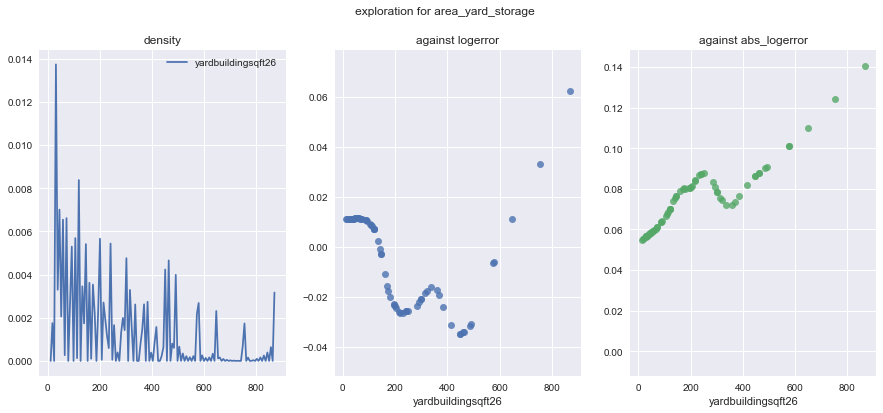

In [98]:
prop_missing, train_missing = missing_ratio('yardbuildingsqft26')
visual_analysis_num('yardbuildingsqft26', 'area_yard_storage')

In [99]:
# missing rate too high for training
feature_info['yardbuildingsqft26'] = ['area_yard_storage', 'num', 4, prop_missing, train_missing]

### yearbuilt

Description:  The Year the principal residence was built. 

missing ratio prop: 0.0160
missing ratio train: 0.0039


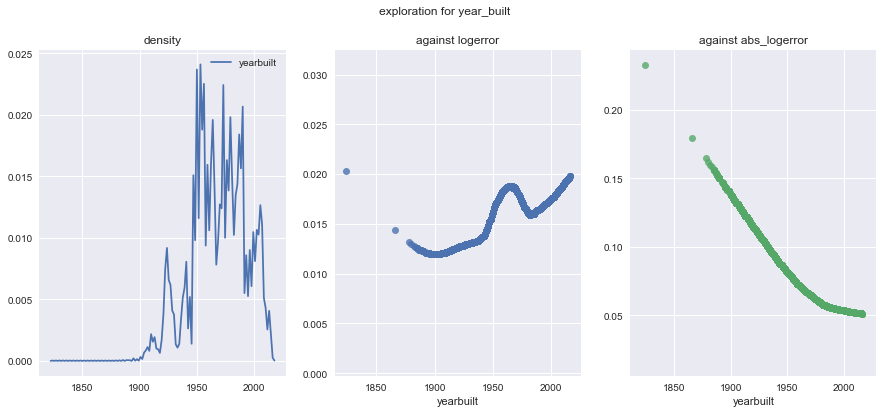

In [100]:
prop_missing, train_missing = missing_ratio('yearbuilt')
visual_analysis_num('yearbuilt', 'year_built')

In [101]:
# high quality feature
feature_info['yearbuilt'] = ['year_built', 'num', 1, prop_missing, train_missing]

### numberofstories

Description: Number of stories or levels the home has. Apprently, it cannot be zero, so Na are true missing.

missing ratio prop: 0.7703
missing ratio train: 0.7732


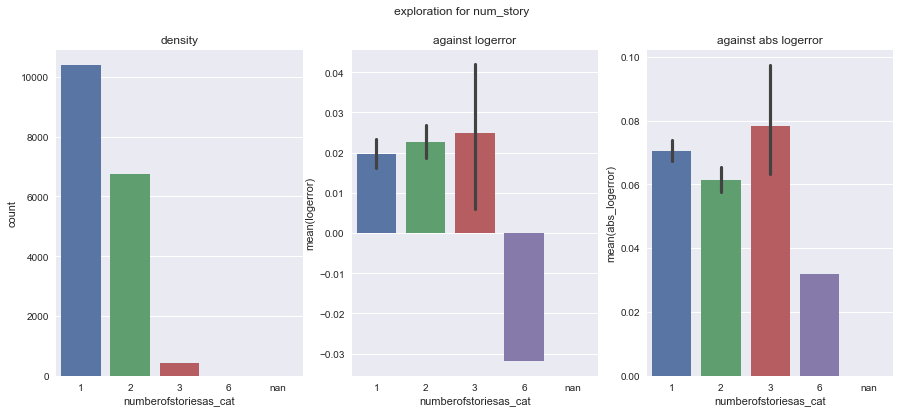

In [102]:
prop_missing, train_missing = missing_ratio('numberofstories')
visual_analysis_num_as_cat('numberofstories', 'num_story')

In [103]:
# missing rate is a bit high, but some pattern between group 1 and 2
feature_info['numberofstories'] = ['num_story', 'num', 2, prop_missing, train_missing]

### fireplaceflag

Description: Is a fireplace present in this home. 

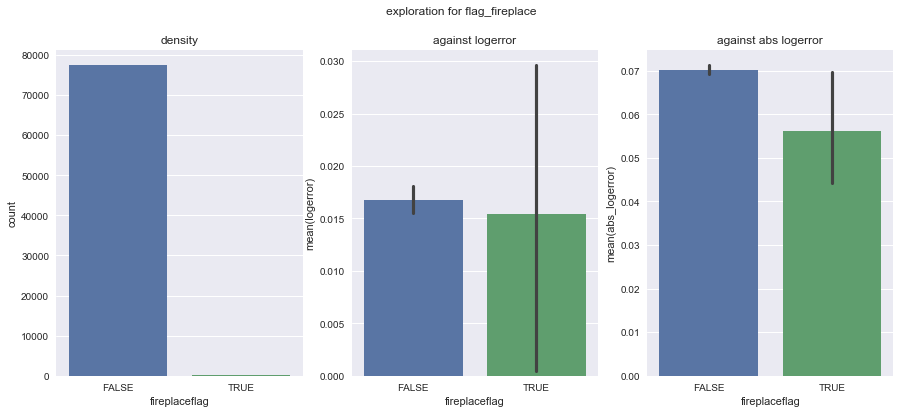

In [104]:
mark_flag_col('fireplaceflag')
visual_analysis_cat('fireplaceflag', 'flag_fireplace')

In [105]:
# too much unbalanced
feature_info['fireplaceflag'] = ['flag_fireplace', 'cat', 4, 0.0, 0.0]

### structuretaxvaluedollarcnt

Description: The assessed value of the built structure on the parcel.

missing ratio prop: 0.0156
missing ratio train: 0.0019


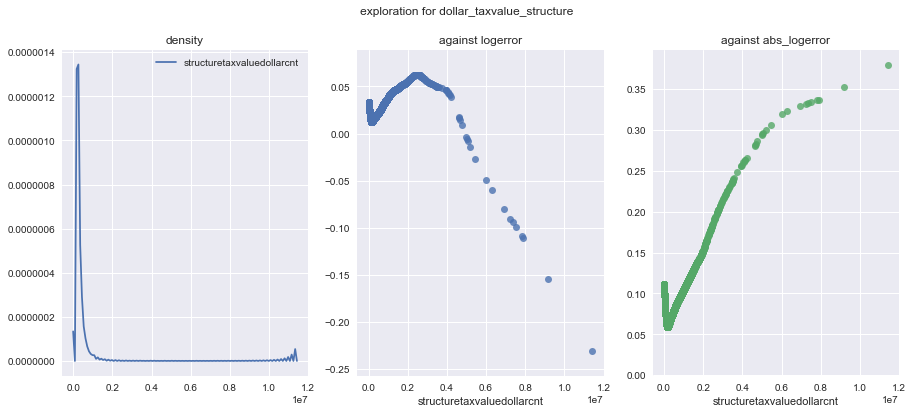

In [106]:
prop_missing, train_missing = missing_ratio('structuretaxvaluedollarcnt')
visual_analysis_num('structuretaxvaluedollarcnt', 'dollar_taxvalue_structure')

In [107]:
# the distribution is quite concentraded, but there is pattern there.
feature_info['structuretaxvaluedollarcnt'] = ['dollar_taxvalue_structure', 'num', 1, prop_missing, train_missing]

### taxvaluedollarcnt

Description: The total tax assessed value of the parcel.

missing ratio prop: 0.0115
missing ratio train: 0.0005


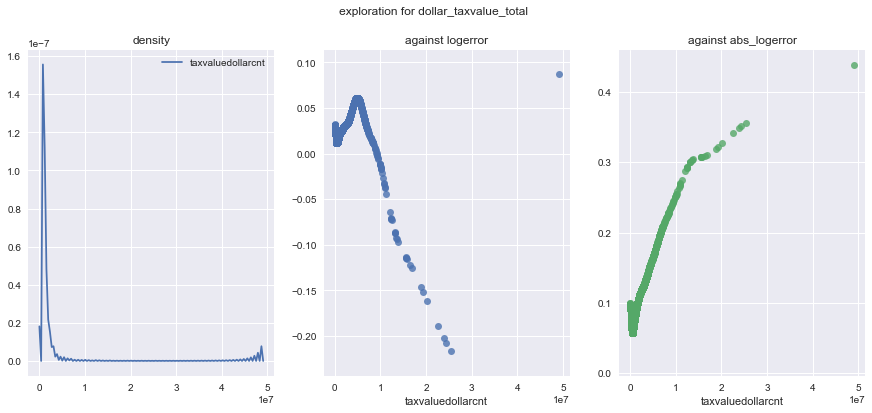

In [108]:
prop_missing, train_missing = missing_ratio('taxvaluedollarcnt')
visual_analysis_num('taxvaluedollarcnt', 'dollar_taxvalue_total')

In [109]:
# low missing rate, rich pattern in high density area.
feature_info['taxvaluedollarcnt'] = ['dollar_taxvalue_total', 'num', 1, prop_missing, train_missing]

### assessmentyear

Description: The year of the property tax assessment. All values 2015 without missing, useless 'feature'.

In [110]:
feature_info['assessmentyear'] = ['year_assess', 'cat', 4, 0.0, 0.0]

### landtaxvaluedollarcnt

Description: The assessed value of the land area of the parcel.

missing ratio prop: 0.0201
missing ratio train: 0.0005


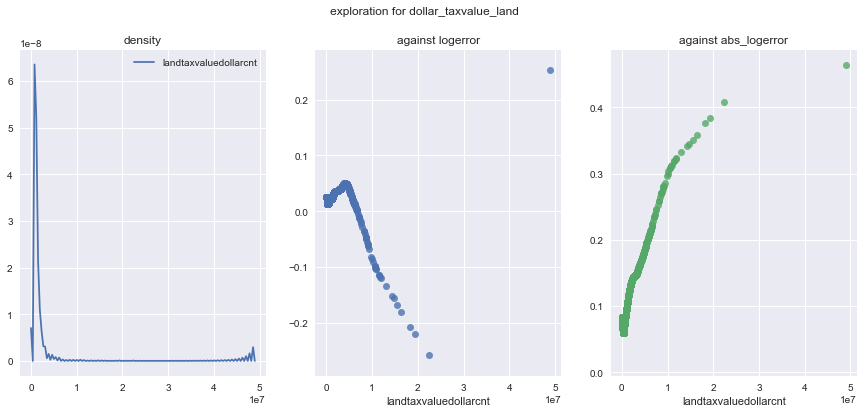

In [111]:
prop_missing, train_missing = missing_ratio('landtaxvaluedollarcnt')
visual_analysis_num('landtaxvaluedollarcnt', 'dollar_taxvalue_land')

In [112]:
# again rich pattern, and different from 2 above
feature_info['landtaxvaluedollarcnt'] = ['dollar_taxvalue_land', 'num', 1, prop_missing, train_missing]

### taxamount

Description: The total property tax assessed for that assessment year. 

missing ratio prop: 0.0076
missing ratio train: 0.0005


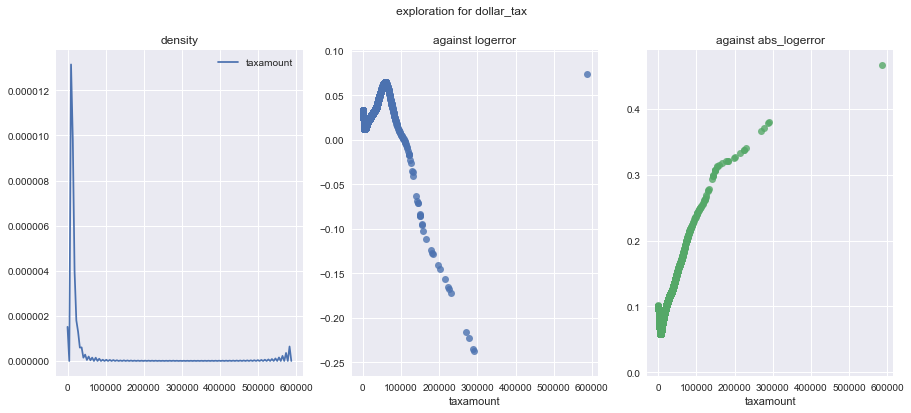

In [113]:
prop_missing, train_missing = missing_ratio('taxamount')
visual_analysis_num('taxamount', 'dollar_tax')

In [114]:
# another pattern-rich feature
feature_info['taxamount'] = ['dollar_tax', 'num', 1, prop_missing, train_missing]

### taxdelinquencyflag

Description: Property taxes for this parcel are past due as of 2015. Note, it is a flag variable with 'Y' and na only.

number of TRUE: 2900


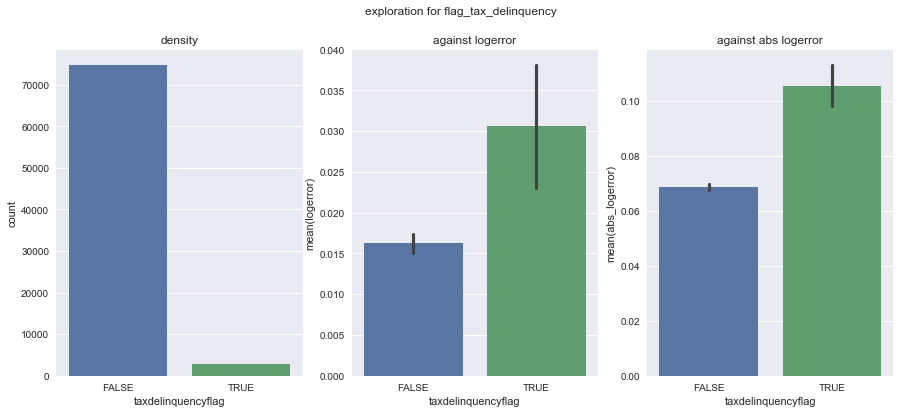

In [115]:
recover_col('taxdelinquencyflag')
prop_data_marks_true = prop_data['taxdelinquencyflag'] == 'Y'
prop_data.loc[prop_data.index[prop_data_marks_true], 'taxdelinquencyflag'] = 'TRUE'
prop_data.loc[prop_data.index[~prop_data_marks_true], 'taxdelinquencyflag'] = 'FALSE'
train_data_marks_true = train_data['taxdelinquencyflag'] == 'Y'
train_data.loc[train_data.index[train_data_marks_true], 'taxdelinquencyflag'] = 'TRUE'
train_data.loc[train_data.index[~train_data_marks_true], 'taxdelinquencyflag'] = 'FALSE'

visual_analysis_cat('taxdelinquencyflag', 'flag_tax_delinquency')
print('number of TRUE: %d' % (np.sum(train_data['taxdelinquencyflag'] == 'TRUE')))

In [116]:
# pattern is obvious, but distribution is quite unbalanced. However overall quality should be better than current class features.
feature_info['taxdelinquencyflag'] = ['flag_tax_delinquency', 'cat', 1, 0.0, 0.0]

### taxdelinquencyyear

Description: Year for which the unpaid propert taxes were due.

missing ratio prop: 0.9811
missing ratio train: 0.9626


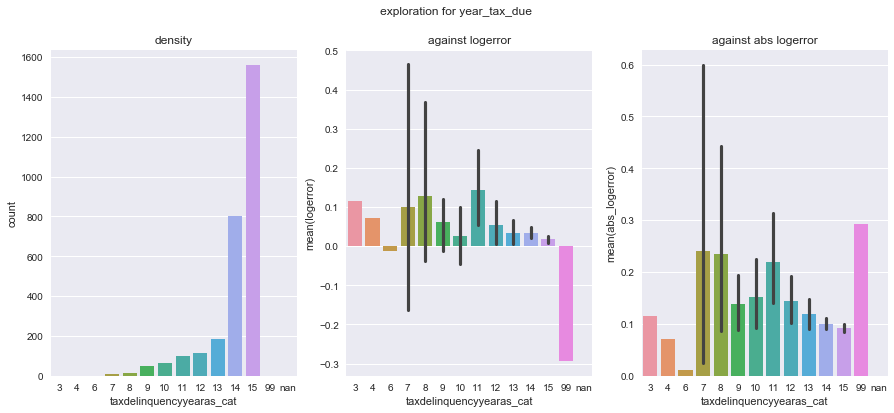

In [117]:
prop_missing, train_missing = missing_ratio('taxdelinquencyyear')
visual_analysis_num_as_cat('taxdelinquencyyear', 'year_tax_due')

In [118]:
# too high missing rate. drop it
feature_info['taxdelinquencyyear'] = ['year_tax_due', 'cat', 4, 0.0, 0.0]

### censustractandblock

Description: Census tract and block ID combined - also contains blockgroup assignment by extension. 14 digit string, again first 4 digits are fips. decompose into census_tract and block as 6 vs. 4 digits string

In [119]:
recover_col('censustractandblock')
prop_missing, train_missing = missing_ratio('censustractandblock')

def census_info_split_inner(data):
    data['census'] = data['censustractandblock'].apply(lambda x: x[4:10] if not x == 'nan' else np.nan)
    data['block'] = data['censustractandblock'].apply(lambda x: x[10:] if not x == 'nan' else np.nan)

if not prop_data['censustractandblock'].dtype == 'O':
    prop_data['censustractandblock'] = prop_data['censustractandblock'].apply(lambda x: str(int(x)) if not np.isnan(x) else 'nan')
if not train_data['censustractandblock'].dtype == 'O':
    train_data['censustractandblock'] = train_data['censustractandblock'].apply(lambda x: str(int(x)) if not np.isnan(x) else 'nan')

census_info_split_inner(prop_data)
census_info_split_inner(train_data)
print('n categories census: %d' % len(train_data['census'].unique()))
print('n categories block: %d' % len(train_data['block'].unique()))

missing ratio prop: 0.0251
missing ratio train: 0.0036
n categories census: 2983
n categories block: 664


In [120]:
feature_info['censustractandblock'] = ['census_block', 'none', 4, prop_missing, train_missing]
feature_info['census'] = ['census', 'cat', 3, prop_missing, train_missing]
feature_info['block'] = ['block', 'cat', 3, prop_missing, train_missing]

In [121]:
# save_feature_info_to_csv()